# PZ-model prior $p(x,y)$

Fourier transform convention: (same as Eq. 1 in FT wiki page):

$$ \tilde{f}(x) = \int f(t) e^{-2\pi i xt} dt $$

This is equivalent to choosing units Hz (or kHz) for $x$ rather than rad/s or rad/msec. See `test_core.ipynb` for more on this. Also equivalent to a Laplace transform with $s = 2\pi i x$.

The formula for

$$p_k = -\pi y_k + 2\pi i x_k$$

comes from -3 dB bandwidth point and Fourier convention (since $x$ and $y$ are in kHz rather than rad/msec -- that's why we have to multiply by multiples of $\pi$). We use kHz for $p$ because $t$ is given in msec.

## Model

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p, c) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

But now each coefficient $c_k$ is determined by 2 free parameters $(a_k,b_k) \in \mathbb{R}$:

$$ c_k = {a_k - ib_k \over 2} \iff (a_k = c_k + c_k^*, b_k = ic_k - ic_k^*)$$

such that

$$ c_k e^{p_k t} + c_k^* e^{p_k^* t} = (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) $$

The transfer function follows immediately from the form of the impulse response $h(t; p)$:

$$ \tilde{h}(x; p) = \sum_{k=1}^K {c_k \over 2\pi i x - p_k} + {c_k^* \over 2\pi i x - p_k^*} $$

[Note that the AP model can also be written in this way, but the expression for $c_k$ is more involved (the excluded pole product).]

In this form it is easy to see that the analytical spectral tilt at $x \rightarrow \infty$ should be about -6 dB/oct, independent of $K$, since $\tilde{h}(\infty, p) \propto 1/x$. Ofcourse the amplitudes can conspire in a variety of ways such that things cancel out and the tilt is steeper than that. The most extreme example is the AP model in which the model collapses to an AP model with characteristic (and huge) $(-12K)$ dB/oct tilt.

Collecting the terms, we get a proper transfer function in rational form:

$$ \tilde{h}(x; p) = {N(2\pi i x) \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

where $N(2\pi i x)$ is a polynomial of degree at most $2K - 1$.

## Scaling

*Scaling is necessary to get O(1) impulse responses such that the generated speech $d(t)$ is also of O(1).*

We scale the impulse response a priori by using the ME prior for the amplitudes that yields a MVN over $(a,b)$ directly. Below we show that this yields superior normalization compared to AP -- it yields impulse responses $h(t; p)$ whose peak amplitudes are O(1), just what we like because our data peak amplitude is O(2) and our source DGF peak amplitude is O(5).

Then during inference we regularize wrt. the impulse response energy $\mathcal{E}(p, c) = \int h(t)^2 dt$ such that it is O(1) msec. This works really well.

### More on normalization

Unfortunately, it is not so easy to derive constraints on the energy or power (i.e. energy over a time interval divided by the time interval's length). The energy (i.e. $\int h(t)^2 dt$) of the impulse response is by Parseval's theorem equal to the energy contained in the transfer function, but it's not possible to derive hard constraints -- [energy is not preserved by convolution!](https://math.stackexchange.com/a/1154656/566289). [The best I got is $\int_0^\tau d(t)^2 dt \approx \tau \leq \int |\tilde{h}(x)|^4 dx \int |\tilde{u}(x)|^4 dx$].

A more useful way to proceed is to rely on the typical values of peak amplitudes -- these are typically of the same order as the squared power of the signal -- because we know that these must be of the same order for $d$, $u$, $h$ if we the output $d(t)$ is to be "made" from a convolution of $u$ and $h$. (This is necessarily heuristical, since analytic guarantees are quite involved (Pfeiffer 1954).) But it turns out this works really well.

**Note:** The only thing we can assert about power is that $|\tilde{h}(x; p)| \leq 1$ for all frequencies $x$ if we believe that the [VTR is a passive filter](https://dsp.stackexchange.com/a/28881/65430). But I think the lossless open tube model of the VTR is in fact active by this criterion, so best to stay away from this. In any case it is quite difficult to normalize for the passive condition and keep everything tractable.

## Do poles measure VTRs?

"Formants are easy to measure, VTRs aren't" @Whalen2022

In our view, poles are simply an expansion of the "true" transfer function. And we focus on formants, which are highly nonlinear functions of the poles.

Therefore, it is dangerous to identify them directly with VTRs, especially in such a simple linear approximation to the system (i.e., source-filter theory). For example, pole (resonance) amplitudes are not free parameters; they are determined by all the poles together -- this seems like a strong simplification: surely the resonance amplitude should be a free parameter? (For example by expanding the transfer function in a Gaussian mixture.)

Contra AP model:
- Less expressibility; a higher number of poles is necessary to emulate zeros
  in the transfer function...
- ... and the amplitudes and phases of the sinusoids are not independent; you need extra poles to control those. *This makes it even more clear that poles are just expansion terms*.
  > Indeed, learning that spectrum analysis problems can be formulated in AR terms amounts to little more than discovering the Mittag-Leffler theorem of complex variable theory (under rather general conditions an analytic function is determined by its poles and residues). [@Jaynes1987, p. 3]

**Nevertheless**, if one wants to measure VTRs, the way one would do this is full Bayesian model selection for the number of poles $K(D)$, ($D$ is the given data speech waveform) rather than assuming a fixed model $K = 16$. Then we can assume $K(D) \geq 3$, since the minimum amount of formants is 3, and those can be described in the simplest case by just 3 poles (and this would require that the formant amplitudes are indeed just functions of the 3 poles).

## Comparison with AP model

Disadvantages:
- Roughly twice as much parameters: $(4K)$ (PZ) instead of $(2K+1)$ (AP)

Advantages:
- Automatically regularizes itself ("nested model")
- Can model more realistic spectral tilt
- Can model zeros more easier, and more sharp features of the spectrum in general
- Independent amplitudes of the formant peaks, which seems intuitively desirable

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

from vtr.prior import polezero

2022-11-30 12:56:49.068385: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## The amplitude prior

[Based on: von der Linden (2014) Eq. (21.67) p. 348-349] Note we use $E \equiv \mu^2$ as a constraint parameter, not as the number of basis functions in the expansion. The notation in von der Linden makes no sense for us, since $[\mu^2] = [\text{time}]$ -- it is not quadratic at all.

The impulse response is just a basis function expansion with $K$ terms with amplitudes $a_k, b_k$:
$$ \begin{align}
h(t; p) &= (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t} \\
&= (t \geq 0) \times \sum_{k=1}^K (a_k \cos(2\pi i x_k) + b_k \sin(2\pi i x_k)) \exp(-\pi y_k t) \\
&= \sum_{i=1}^{2K} \alpha_i \phi_i(t)
\end{align}$$
where $(\alpha_i = a_i \text{ if $i \leq K$ else } b_{i-K})$.

So we can assign a prior to the amplitudes based on the energy (wrongly called $P(a)$ suggesting power -- but power needs to be divided by time) of the impulse response:
$$
\mathcal{E}(\alpha) = \int dt \ h(t; p, \alpha)^2 = \sum_{ij=1}^{2K} \alpha_i \alpha_j S_{ij} := E
$$
Here $S_{ij}$ is the overlap matrix which can be calculated analytically.
Similar calculations are done in @Bretthorst1991 in the discrete time domain, but our continous formulation (the $\int$ instead of $\sum$) allows for efficient close-form formulas. These are given in `vtr/overlapmatrix.nb`. Then the ME prior for the amplitudes given the poles $p$ is
$$ p(\alpha|p,E) \equiv p(a,b|p,E) = MVN(0, \Sigma) $$ where $$ \Sigma = {E \over 2K} S(p)^{-1}$$.

Note that $S_{ij}$ and $E$ have dimensions of time. In our case we assign $E = O(1) = 1\ msec$.
Why?
The normalized-to-unit-power speech data has typical peak amplitude O(2).
The source prior typically yields O(5) peak amplitude in DGF waveform.
Therefore we want our impulse response $h(t)$ to have O(1) peak amplitude.
This is well accomplished by setting $E = 1\ msec$.

(BTW: this is an example of why it is good to work in a scale where things are O(1), so that O(1) guesses for parameter are likely to succeed without putting any thought in it.)

In [2]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]310.8s, 5.2min  : Loading get_vtrformants_training_data...


[Memory]312.5s, 5.2min  : Loading run_nested...
[Memory]315.4s, 5.3min  : Loading run_nested...


energy [msec] = (1.58559459659816, 1.5837033625592645)


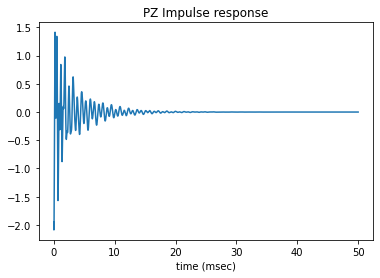

In [101]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)

h = polezero.impulse_response(t, x, y, ab)
plot(t, h)
title("PZ Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, polezero.impulse_response_energy(x, y, ab)))

Test if the expected values $<\mathcal{E}>$ is close to its prescribed value $E = 1\ msec$:

(0.997157398562831, 0.5810818442829337)

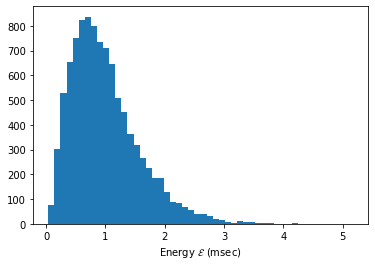

In [102]:
energies = []
for _ in range(10000):
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    energies += [polezero.impulse_response_energy(x, y, ab)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies), std(energies) # msec

## The PZ power spectrum

Here you can see our +/- 6 dB correction to the tilt sensitivity is more or less OK; results are typically within 18 dB.

(-15.517180285165118, -6.020599913279624)

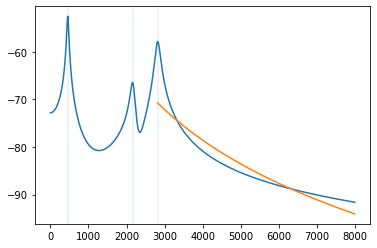

In [103]:
K = 3
x, y = samplexy()

ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = polezero.transfer_function_power_dB(f, x, y, ab)
plot(f, power)
for xi in x: axvline(xi, alpha=.1)
F3 = x[-1]
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True, cutoff=F3)
plot(f[f>F3], interp(f[f>F3]))
tilt, polezero.analytical_tilt()

## Fitting the TFB samples

In [18]:
samples = bandwidth.get_TFB_samples()

[Memory]1324.4s, 22.1min: Loading get_TFB_samples...


For `source.ipynb`, we could get away with 50 samples (although more wouldn't hurt either): small problem dimensionality and only one parameter to condition on. Here we have a much larger dimensionality and we will generally fix 4 parameters (being $\hat T$, $\hat F_1^R$, $\hat F_2^R$, $\hat F_3^R$). So we take 200 = 4 times more samples. This seems to do the trick. 

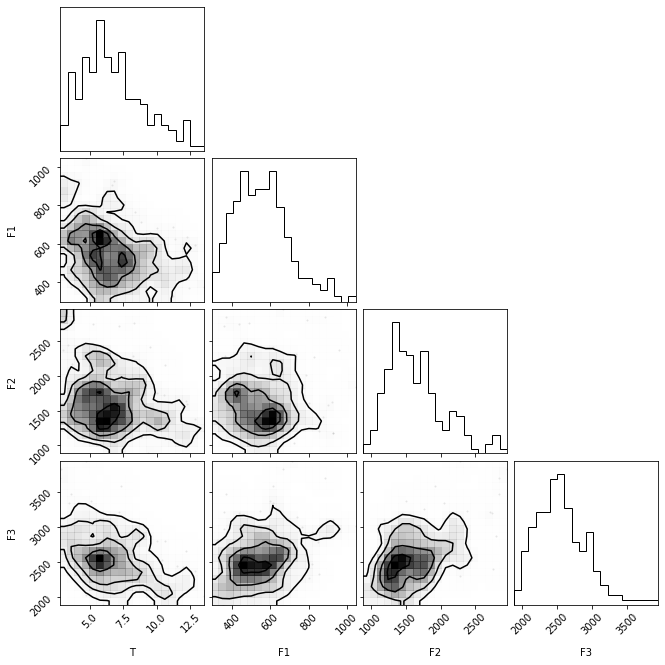

In [21]:
# Did we cover the (T, F^Ref) space sufficiently?
import corner
TF = np.vstack([np.array((s['T'], *s['F'])) for s in samples])
corner.corner(TF, smooth=1., labels=("T", "F1", "F2", "F3"));

In [22]:
fitted = polezero.get_fitted_TFB_samples()

[Memory]1555.4s, 25.9min: Loading get_TFB_samples...
________________________________________________________________________________
[Memory] Calling vtr.prior.polezero.run_nested...
run_nested(34454999, {'bootstrap': 10, 'nlive': 36, 'sample': 'rslice'}, {'maxcall': 10000000, 'save_bounds': False})


21it [00:04,  4.97it/s, bound: 2 | nc: 87 | ncall: 1850 | eff(%):  1.135 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.045] 


KeyboardInterrupt: 

In [23]:
K = 6
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*50+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

In [81]:
K = 5
sample = samples[10]

results = polezero.fit_TFB_sample(sample, K, 111111110000) # with energy

________________________________________________________________________________
[Memory] Calling vtr.prior.polezero.run_nested...
run_nested(111111110000, {'bootstrap': 10, 'nlive': 60, 'sample': 'rslice'}, {'maxcall': 10000000, 'save_bounds': False})


1466it [10:49,  2.26it/s, +60 | bound: 69 | nc: 1 | ncall: 193494 | eff(%):  0.789 | loglstar:   -inf < -0.942 <    inf | logz: -22.487 +/-    nan | dlogz:  0.001 >  0.069]    

____________________________________________________run_nested - 649.7s, 10.8min


Summary
nlive: 60
niter: 1466
ncall: 193434
eff(%):  0.789
logz: -22.487 +/-  0.603


None

'Information (bans)'

7.909449692708919

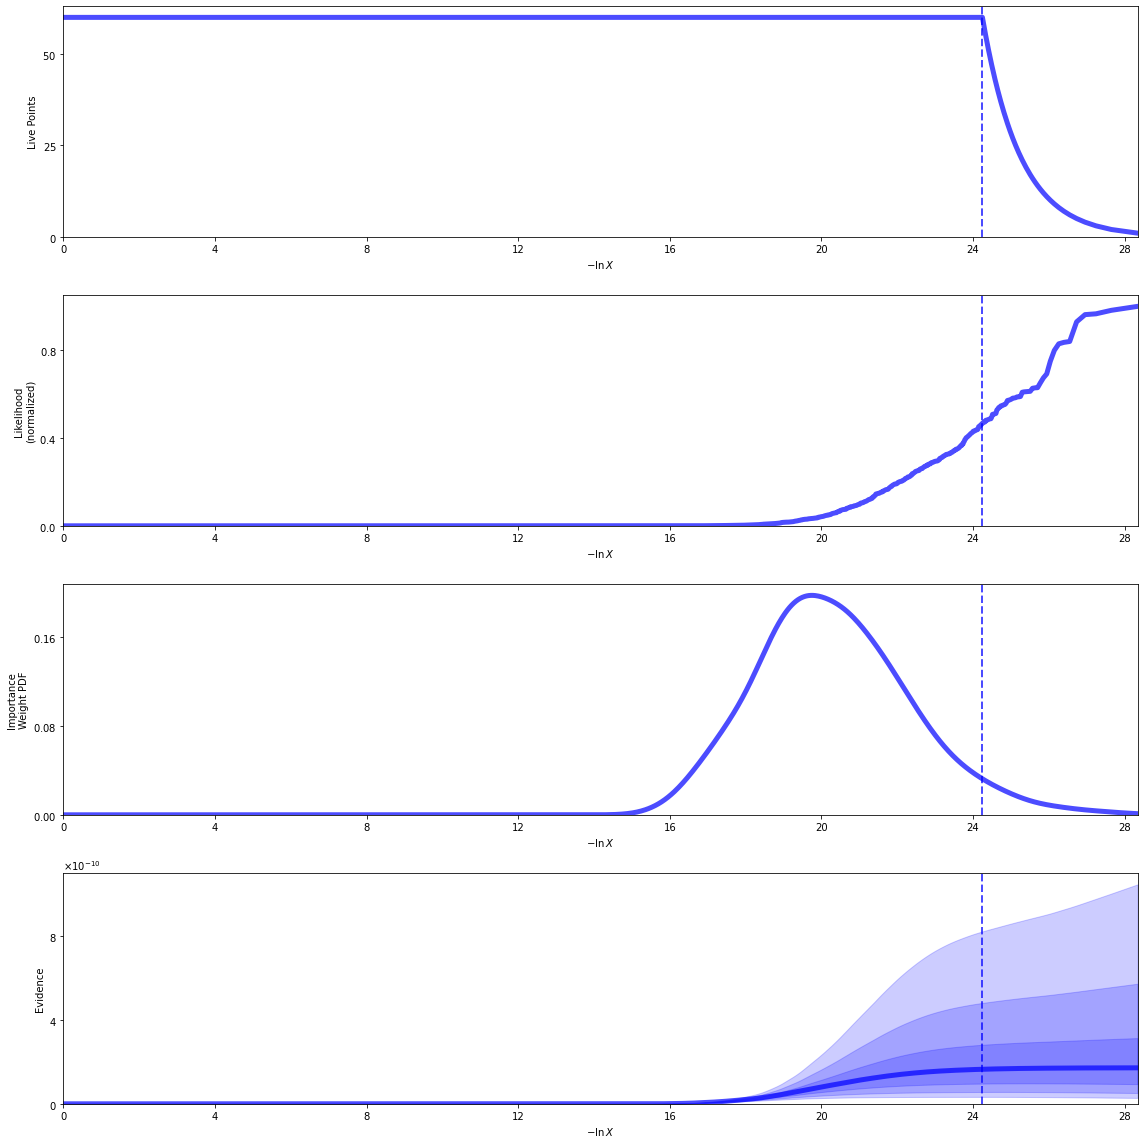

Quantiles:
x [(0.025, 230.71092778102286), (0.5, 348.210670949563), (0.975, 636.1306187848769)]
Quantiles:
x [(0.025, 619.766225914595), (0.5, 632.3314221673203), (0.975, 1436.1549675524443)]
Quantiles:
x [(0.025, 1351.7368786606469), (0.5, 1427.0699399416524), (0.975, 2384.9431155124503)]
Quantiles:
x [(0.025, 1412.917820788912), (0.5, 1537.5378361246085), (0.975, 2637.3776556499965)]
Quantiles:
x [(0.025, 2304.416272701383), (0.5, 2357.4443811067604), (0.975, 3030.984038907837)]
Quantiles:
y [(0.025, 84.1304400390544), (0.5, 424.3323507898385), (0.975, 1228.7923180344399)]
Quantiles:
y [(0.025, 55.745825069864395), (0.5, 81.24029669176215), (0.975, 104.1343560554663)]
Quantiles:
y [(0.025, 20.86188054662911), (0.5, 108.4598900073202), (0.975, 255.39458227685546)]
Quantiles:
y [(0.025, 167.93610637318108), (0.5, 944.7394752084724), (0.975, 3053.104897472862)]
Quantiles:
y [(0.025, 159.70656334317934), (0.5, 269.30606366694064), (0.975, 4057.00728658919)]
Quantiles:
a [(0.025, -0.90556

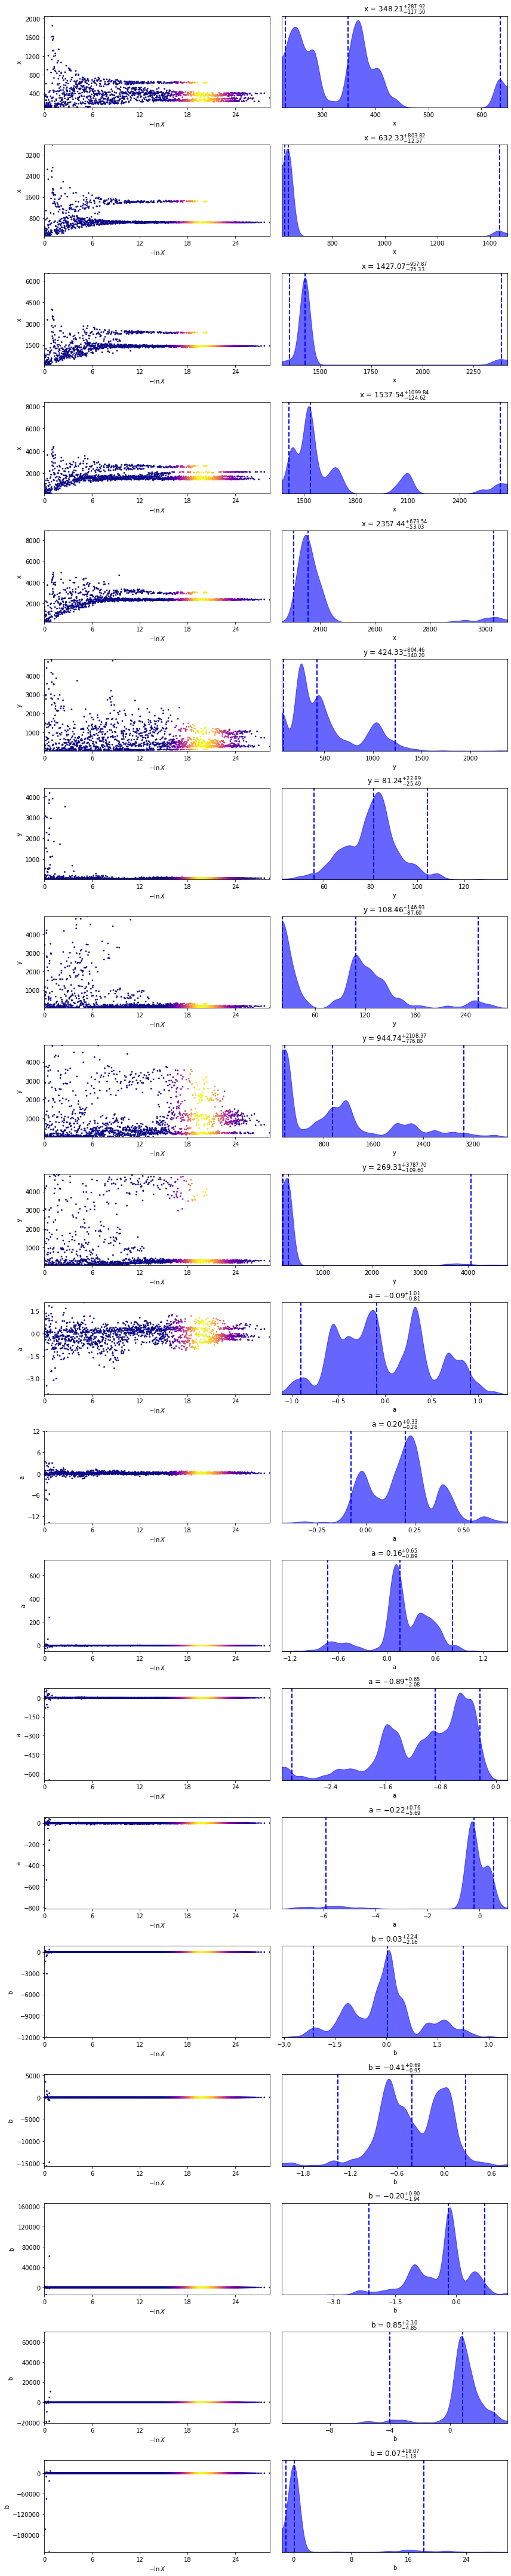

In [82]:
from lib import util
util.dyplot(results, (*["x"]*K, *["y"]*K, *["a"]*K, *["b"]*K), cornerplot=False)

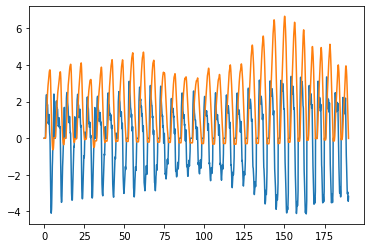

In [83]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

[ 624. 1440. 2386.] [ 632.04 1432.81 2379.83]
[ 40.65  71.92 145.48] [ 42.85  67.69 144.58]
3.2729740698565832 0.377398425049081 1.298389363291962 0.18082050972009514
mu2(analytical) [msec] = 0.5747700507724143


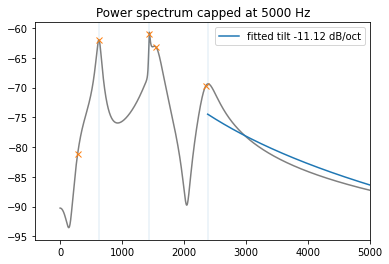

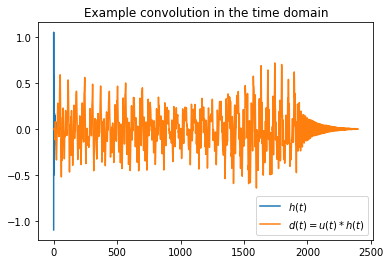

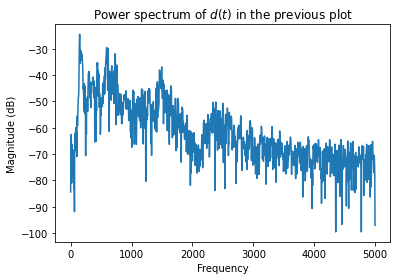

-2.5647911839588606

In [100]:
from IPython.display import Audio
from vtr.prior.polezero import *

def unpack(params):
    xy, ab = np.split(params, 2)
    x, y = np.split(xy, 2)
    return x, y, ab

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F=constants.SIGMA_FB_REFERENCE_HZ,
    sigma_B=constants.SIGMA_FB_REFERENCE_HZ,
    tilt_target=constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt=constants.SIGMA_TILT_DB,
    energy_target=constants.IMPULSE_RESPONSE_ENERGY_MSEC,
    sigma_energy=constants.SIGMA_IMPULSE_RESPONSE_ENERGY_MSEC
):
    x, y, ab = unpack(params)
    
    # Calculate pole-zero transfer function
    power = transfer_function_power_dB(f, x, y, ab)

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = F_true[-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = impulse_response_energy(x, y, ab)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2
    energy_err = ((energy - energy_target)/sigma_energy)**2
    
    # Print debug information
    print(np.round(F, 2), np.round(F_true, 2))
    print(np.round(B, 2), np.round(B_true, 2))
    print(F_err, B_err, tilt_err, energy_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = transfer_function_power_dB(f, x, y, ab)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = polezero.impulse_response(t, x, y, ab)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))
    
    return -(F_err + B_err + tilt_err + energy_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())